In [1]:
import numpy as np
from numpy import ma
import math
import scipy
import scipy.constants as constants
import os
from IPython.display import Image

from netCDF4 import Dataset

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker

# from matplotlib.mlab import bivariate_normal

NA = 6.022e+23

In [2]:
# Lagrange: 2x2.5

FILEDIR0 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/final_continuous_injection/gc_2x25_lagrange_final'
NcFile0   = Dataset(FILEDIR0+'/OutputDir/GEOSChem.SpeciesConc.20150101_0005z.nc4','r',format='NETCDF4_CLASSIC')

lat0             = NcFile0.variables['lat'][:]
lon0             = NcFile0.variables['lon'][:]
LA0              = NcFile0.variables['SpeciesConc_PASV_LA'][:,:,:,:]
LA0_3            = NcFile0.variables['SpeciesConc_PASV_LA3'][:,:,:,:]

LA0 = LA0 + LA0_3

GC_AREA0 = NcFile0.variables['AREA'][:,:]




# Eulerian: 2x2.5
FILEDIR3 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/final_continuous_injection/gc_2x25_eulerian_final'
NcFile3   = Dataset(FILEDIR3+'/OutputDir/GEOSChem.SpeciesConc.20150101_0005z.nc4','r',format='NETCDF4_CLASSIC')

lat3             = NcFile3.variables['lat'][:]
lon3             = NcFile3.variables['lon'][:]
EU3              = NcFile3.variables['SpeciesConc_PASV_EU'][:,:,:,:]

GC_AREA3 = NcFile3.variables['AREA'][:,:];


del NcFile0, NcFile3

In [3]:


Nx3 = len(EU3[0,0,0,:])
Ny3 = len(EU3[0,0,:,0])
Nz3 = len(EU3[0,:,0,0])
Nt3 = len(EU3[:,0,0,0])


Nx0 = len(LA0[0,0,0,:])
Ny0 = len(LA0[0,0,:,0])
Nz0 = len(LA0[0,:,0,0])
Nt0 = len(LA0[:,0,0,0])


In [6]:
#------------------------------------------------
# total air mass in each grid  ------------------
#------------------------------------------------

# 2x2.5
AD_file3 = Dataset(FILEDIR3+'/OutputDir/GEOSChem.StateMet.20150101_0000z.nc4','r',format='NETCDF4_CLASSIC')
GC_AD3   = AD_file3.variables['Met_AD']

# 2x2.5
AD_file0 = Dataset(FILEDIR0+'/OutputDir/GEOSChem.StateMet.20150101_0000z.nc4','r',format='NETCDF4_CLASSIC')
GC_AD0   = AD_file0.variables['Met_AD']

del AD_file0, AD_file3

In [7]:
GC_AD0

<class 'netCDF4._netCDF4.Variable'>
float32 Met_AD(time, lev, lat, lon)
    long_name: Dry air mass
    units: kg
    averaging_method: time-averaged
unlimited dimensions: time
current shape = (31, 72, 91, 144)
filling off

In [8]:
# for Gini and cumulative distribution function (CDF)

In [9]:
### change unit, do average 

LA0_molec = LA0[:,:,:,:]*0.0
for i in range(Nt0):
    LA0_molec[i,:,:,:] = LA0[i,:,:,:]*(GC_AD0[i,:,:,:]*1000.0/28.97)*NA

LA0_Zsum = np.sum(LA0_molec[:,:,:,:], axis=1)
for i in range(Nt0):
    LA0_Zsum[i,:,:]   = LA0_Zsum[i,:,:]/GC_AREA0[:,:]/1e4


EU3_molec = EU3[:,:,:,:]*0.0
for i in range(Nt3):
    EU3_molec[i,:,:,:] = EU3[i,:,:,:]*(GC_AD3[i,:,:,:]*1000.0/28.97)*NA # [mol/mol] to [molec]   

EU3_Zsum = np.sum(EU3_molec[:,:,:,:], axis=1)
for i in range(Nt3):
    EU3_Zsum[i,:,:] = EU3_Zsum[i,:,:]/GC_AREA3[:,:]/1e4 # [molec/cm2]



In [10]:
# delete original variable to save memory
# del LA0, EU1, EU2, EU3, EU4

In [11]:

LA0_area_cumsum_frac_time = []
LA0_mass_cumsum_frac_time = []


EU3_area_cumsum_frac_time = []
EU3_mass_cumsum_frac_time = []


# grid cell area
GC_AREA0_1D = GC_AREA0.reshape(Nx0*Ny0)
GC_AREA3_1D = GC_AREA3.reshape(Nx3*Ny3)

for it in range(Nt0):
    # concentration
    LA0_Zsum_1D = LA0_Zsum[it,:,:].reshape(Nx0*Ny0)
    EU3_Zsum_1D = EU3_Zsum[it,:,:].reshape(Nx3*Ny3)
    

    # grid cell mass for injected tracer
    LA0_molec_Zsum = np.sum(LA0_molec[it,:,:,:], axis=0)
    EU3_molec_Zsum = np.sum(EU3_molec[it,:,:,:], axis=0)
    
    LA0_molec_Zsum_1D = LA0_molec_Zsum.reshape(Nx0*Ny0)
    EU3_molec_Zsum_1D = EU3_molec_Zsum.reshape(Nx3*Ny3)

    # get index for sorted concentration
    LA0_index = LA0_Zsum_1D.argsort()
    LA0_area_sorted = GC_AREA0_1D[LA0_index]
    LA0_mass_sorted = LA0_molec_Zsum_1D[LA0_index]


    EU3_index = EU3_Zsum_1D.argsort()
    EU3_area_sorted = GC_AREA3_1D[EU3_index]
    EU3_mass_sorted = EU3_molec_Zsum_1D[EU3_index]

    
    # cumulative sum
    LA0_area_cumsum = np.cumsum(LA0_area_sorted)
    LA0_mass_cumsum = np.cumsum(LA0_mass_sorted)


    EU3_area_cumsum = np.cumsum(EU3_area_sorted)
    EU3_mass_cumsum = np.cumsum(EU3_mass_sorted)

    # calculate fraction
    length0 = len(LA0_area_cumsum)
    LA0_area_cumsum_frac = LA0_area_cumsum/LA0_area_cumsum[length0-1]
    LA0_mass_cumsum_frac = LA0_mass_cumsum/LA0_mass_cumsum[length0-1]


    length3 = len(EU3_area_cumsum)
    EU3_area_cumsum_frac = EU3_area_cumsum/EU3_area_cumsum[length3-1]
    EU3_mass_cumsum_frac = EU3_mass_cumsum/EU3_mass_cumsum[length3-1]

    
    

    LA0_area_cumsum_frac_time.append(LA0_area_cumsum_frac)
    LA0_mass_cumsum_frac_time.append(LA0_mass_cumsum_frac)

    
    EU3_area_cumsum_frac_time.append(EU3_area_cumsum_frac)
    EU3_mass_cumsum_frac_time.append(EU3_mass_cumsum_frac)


In [12]:
length0,length3

(13104, 13104)

In [13]:
# calculate Gini coefficient

Gini_La0_time,  Gini_Eu3_time= [], []

for it in range(Nt0):
    diag = np.linspace(0,1,100)
    Al = np.trapz(diag, diag)

    LA0 = np.trapz(LA0_mass_cumsum_frac_time[it], LA0_area_cumsum_frac_time[it])

    EU3 = np.trapz(EU3_mass_cumsum_frac_time[it], EU3_area_cumsum_frac_time[it])
    
    Gini_La0 = (Al-LA0)/Al
    Gini_Eu3 = (Al-EU3)/Al
    
    Gini_La0_time.append(Gini_La0)
    Gini_Eu3_time.append(Gini_Eu3)
    
print(Al)
print('Gini_La_Eu')
print(Gini_La0)
print(Gini_Eu3)


0.5
Gini_La_Eu
0.6726592779159546
0.6473539769649506


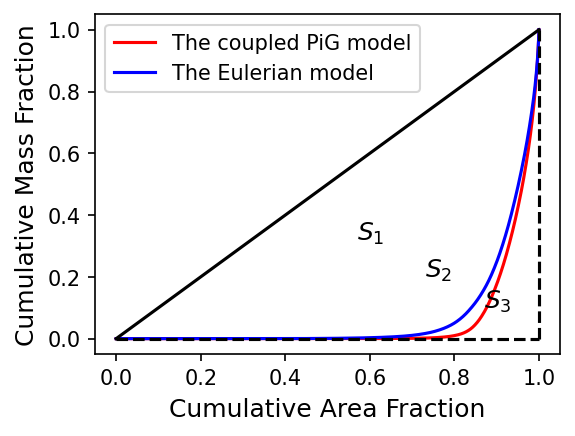

In [24]:
# Plot CFD curve: mass vs. area in the END of the simulation
plt.figure(figsize=(4,3), dpi= 150)

it = 13

plt.plot(LA0_area_cumsum_frac_time[it],LA0_mass_cumsum_frac_time[it],'r',label=f'The coupled PiG model')
plt.plot(EU3_area_cumsum_frac_time[it],EU3_mass_cumsum_frac_time[it],'b',label=f'The Eulerian model')

diag = np.linspace(0,1,30)
plt.plot(diag,diag,'k')

plt.plot(0*diag+1,diag,'k--')
plt.plot(diag,0*diag,'k--')


plt.text(0.57, 0.32, '$S_1$', fontsize=12)
plt.text(0.73, 0.2, '$S_2$', fontsize=12)
plt.text(0.87, 0.1, '$S_3$', fontsize=12)


#plt.legend(loc='upper left')
# plt.title(' Cumulative Fraction from Lower to Higher Concentration')
plt.xlabel('Cumulative Area Fraction', fontsize=12)
plt.ylabel('Cumulative Mass Fraction', fontsize=12)
plt.legend()

plt.savefig('CDF_Area_Mass.png')
# plt.clf();
# plt.cla();
# plt.close();

# Image('CDF_Area_Mass.png') 

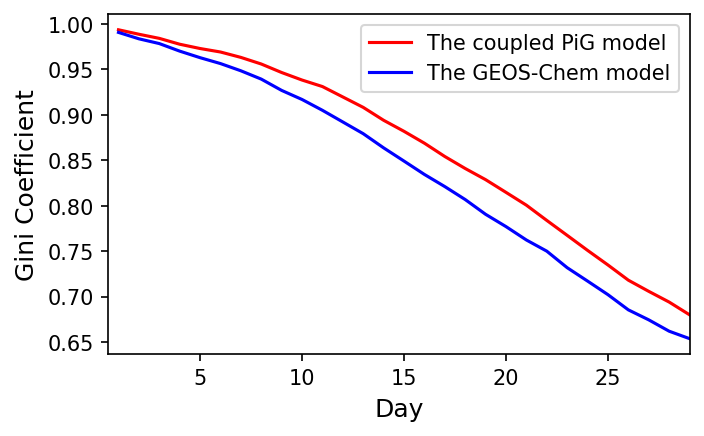

In [25]:
# Plot Gini coefficient at different time:
N_day = 29
days = np.arange(1,N_day+1,1)
plt.figure(figsize=(5,3), dpi= 150)

plt.plot(days,Gini_La0_time[0:N_day],'r',label='The coupled PiG model')
plt.plot(days,Gini_Eu3_time[0:N_day],'b',label='The GEOS-Chem model')


#plt.legend(loc='upper left')
plt.xlim(0.5,len(days))
plt.xlabel('Day',fontsize=12)
plt.ylabel('Gini Coefficient',fontsize=12)
plt.legend();

plt.savefig('Gini_time_series.png')

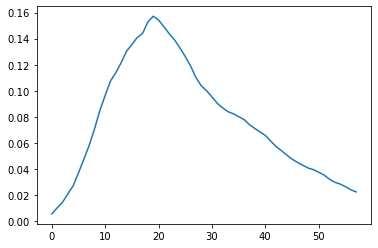

In [14]:
plt.plot( abs(np.array(Gini_La0_time) - Gini_Eu3_time) )